In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
43280,NaN,NaN,International,2020-09-10,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43281,NaN,NaN,International,2020-09-11,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43282,NaN,NaN,International,2020-09-12,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


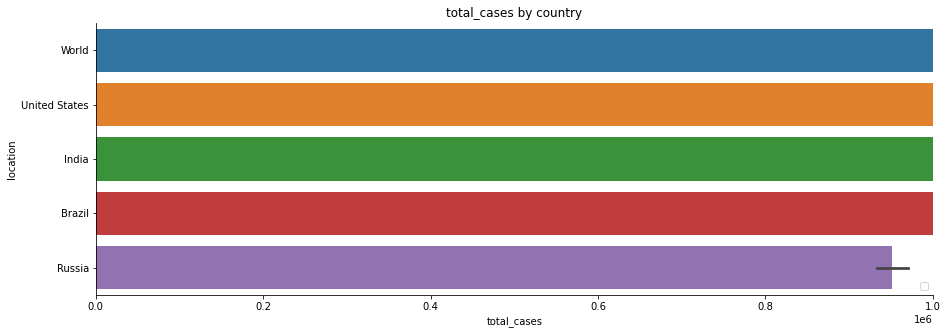

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


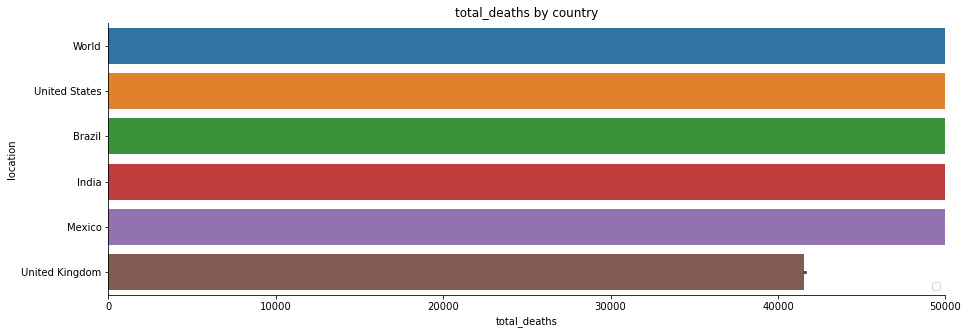

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


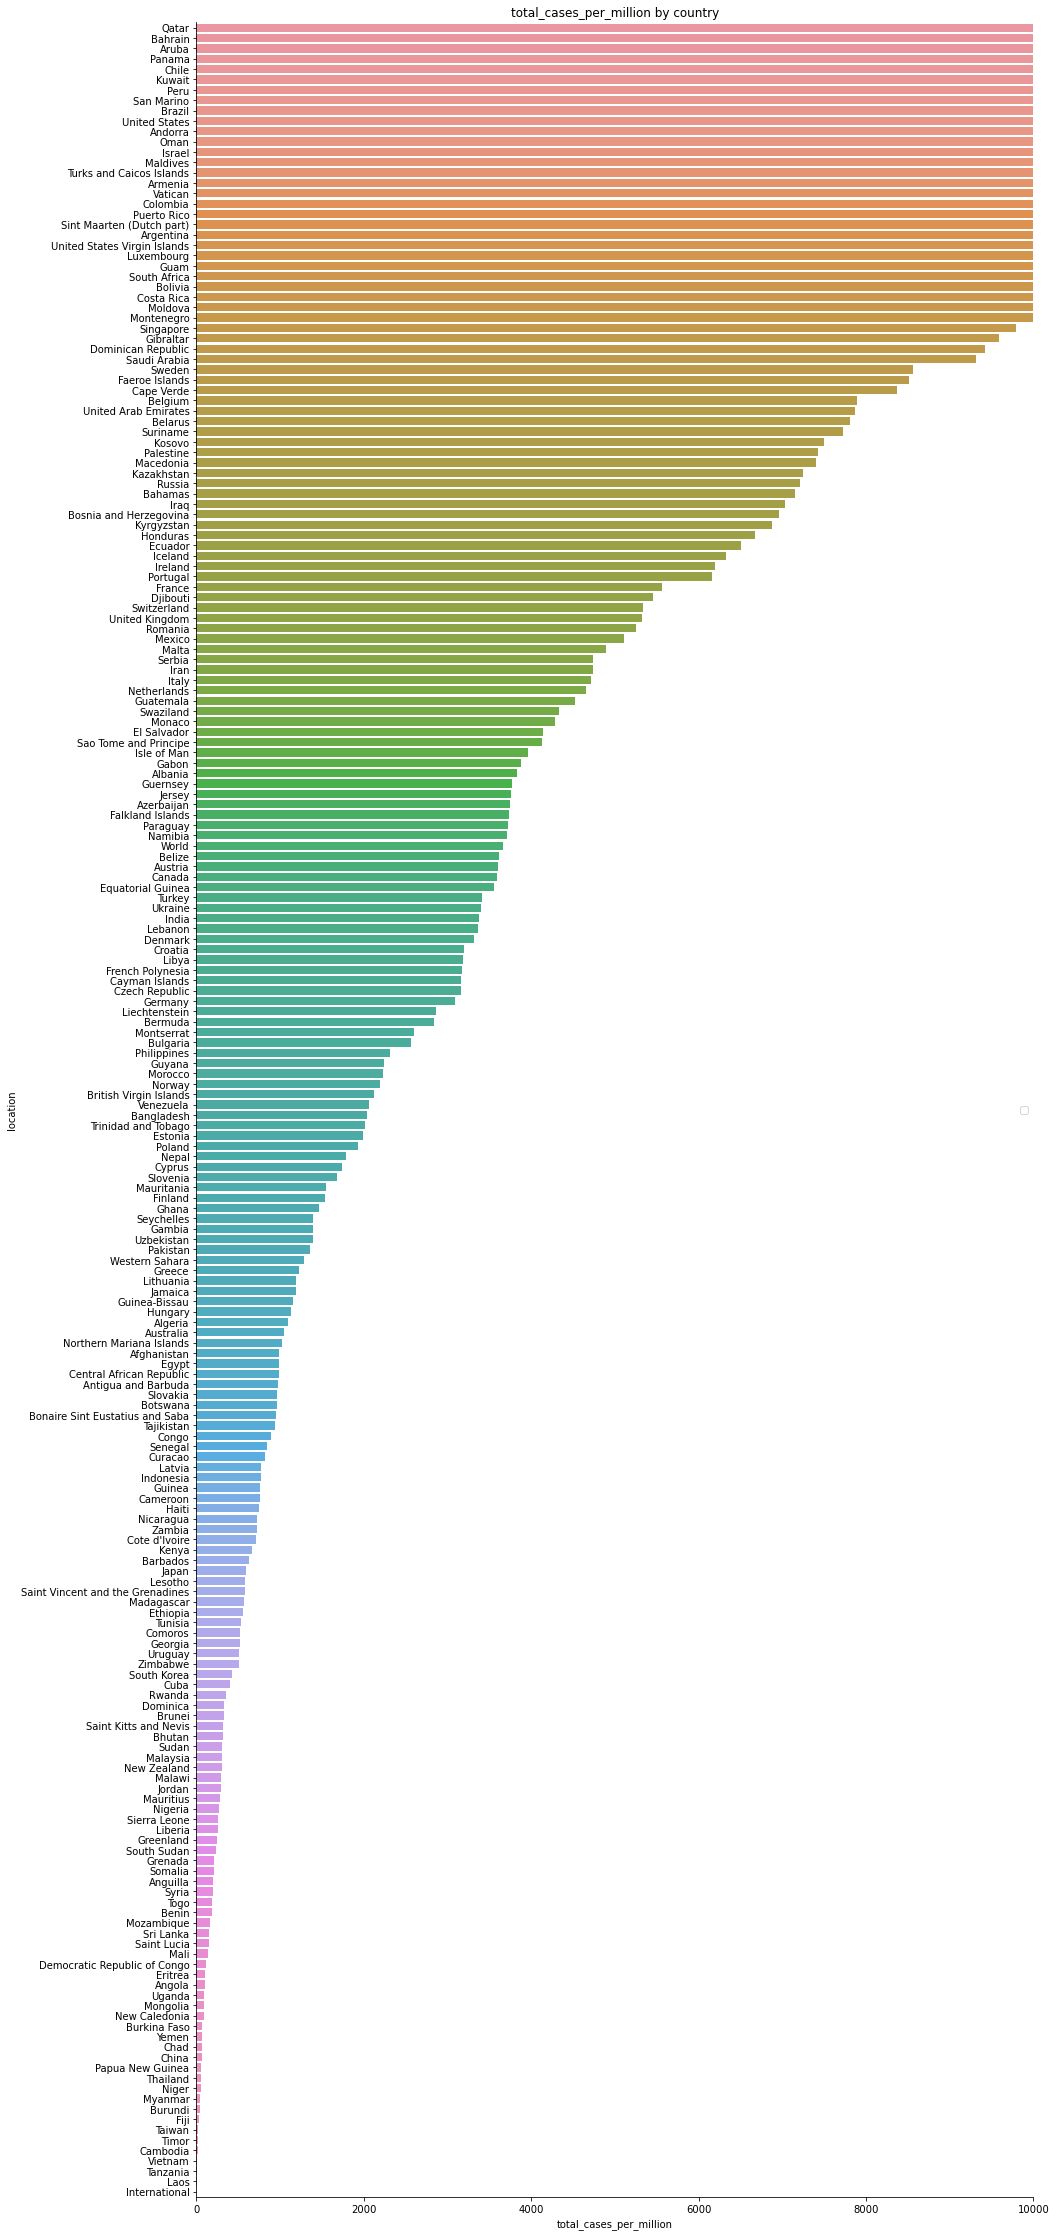

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


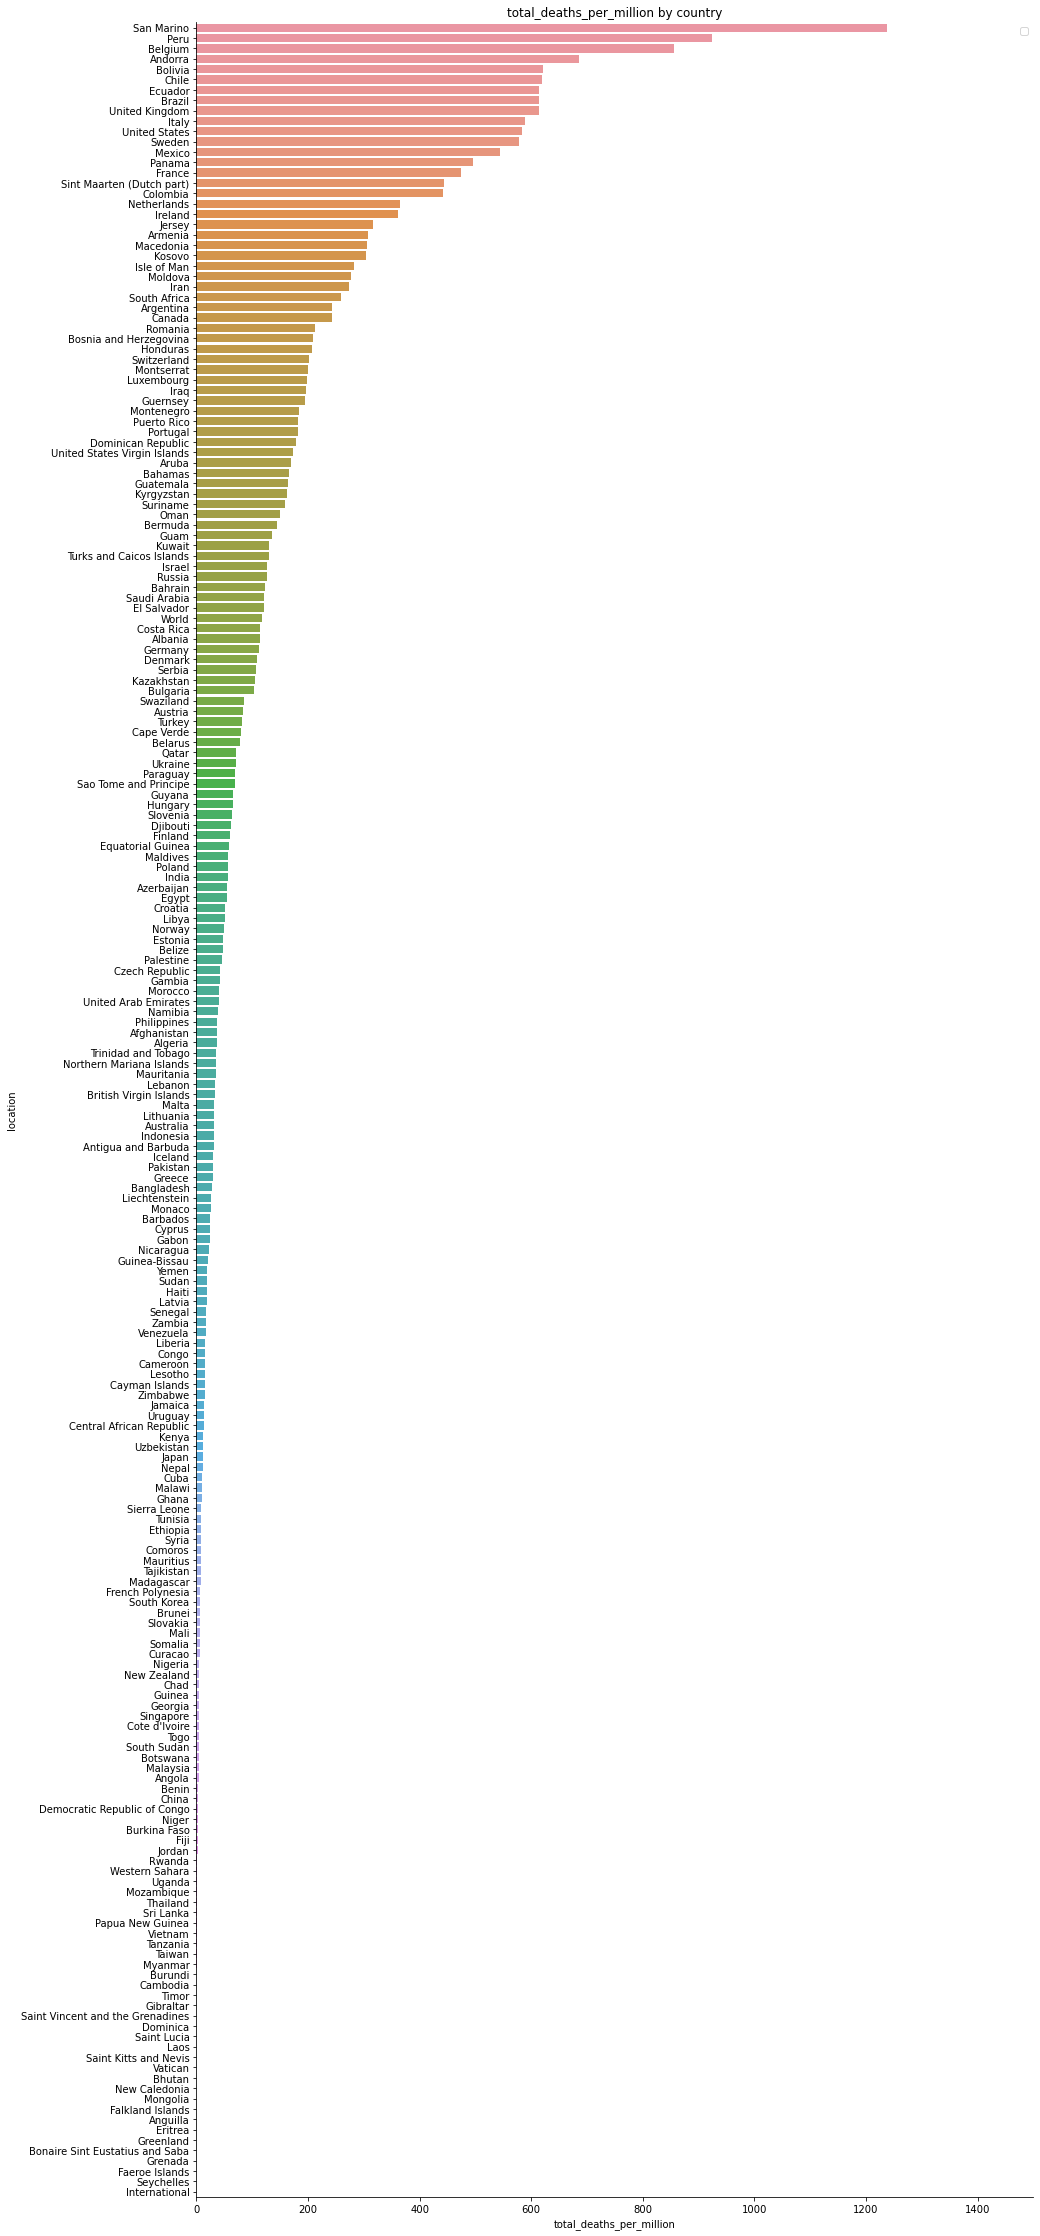

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

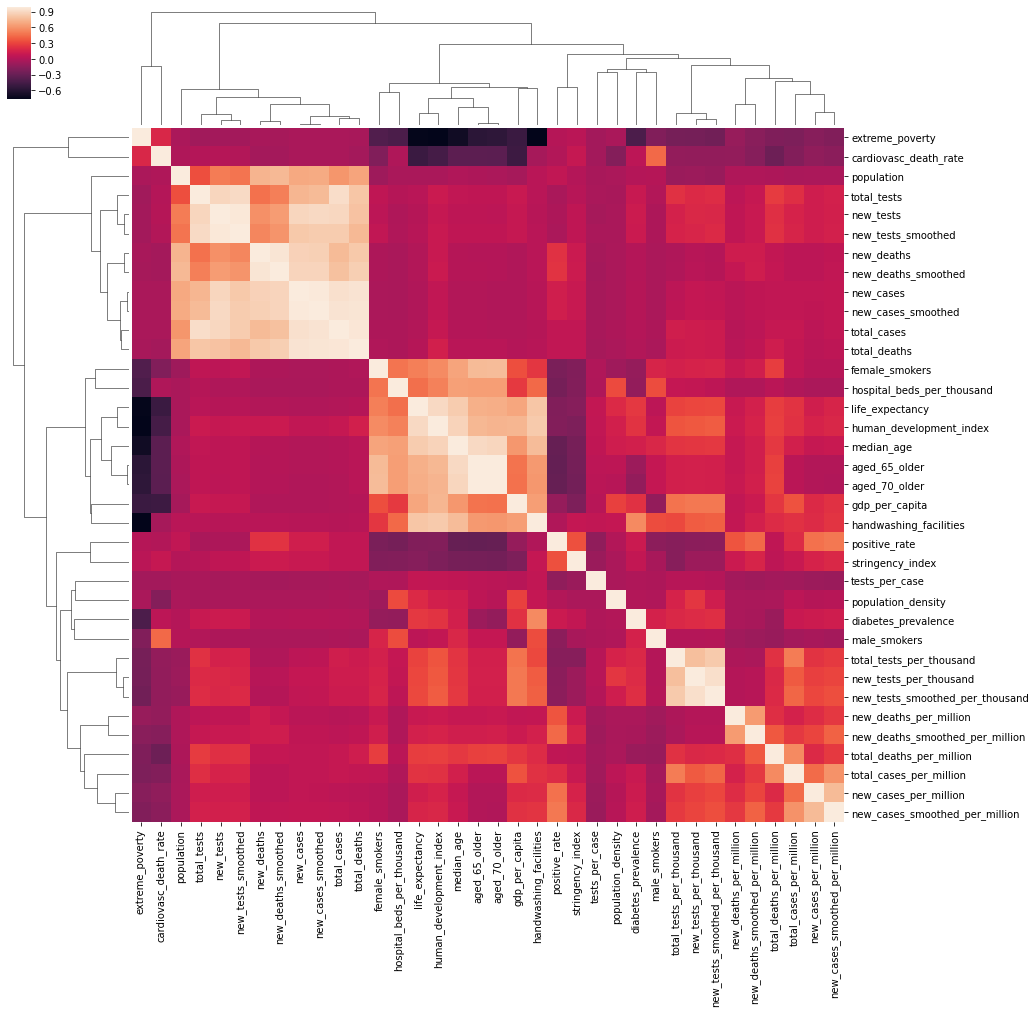

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9989574861444058 (+/- 0.0012231623127602206)
Coef :  [1.03382497e+00 9.18618121e-05 9.44635890e-05]
3 Last_days :  [[27903459 28212728 28516744]]
Today :  28516744
Prediction + :  430849
Tomorow :  28947593
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996525296543268 (+/- 0.00010042298115214637)
Coef :  [0.14943786 0.41804294 0.44287278]
3 Last_days :  [[904077 910127 916005]]
Today :  916005
Prediction + :  8221
Tomorow :  924226
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8943575411243826 (+/- 0.14533024904143246)
Coef :  [-0.75379397  0.77607626  0.98153665]
3 Last_days :  [[344101 353944 363350]]
Today :  363350
Prediction + :  8615
Tomorow :  371965
                                     
--------- Total Death -----------------
                                     
R^2: 0.9545238519673349 (+/- 0.05419449220856621)
Coef :  [-0.74942067  0.7886038   0.95981137]
3 Last_days :  [[30794 30813 30893]]
Today :  30893
Prediction + :  33
Tomorow :  30926
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9471609084713412 (+/- 0.044529227995901206)
Coef :  [-0.32767346 -0.01442683  1.33636575]
3 Last_days :  [[90100 90127 90145]]
Today :  90145
Prediction + :  26
Tomorow :  90171
                                     
--------- Total Death -----------------
                                     
R^2: -98.65788810226803 (+/- 140.82904343098434)
Coef :  [-0.07733507  0.01245852  1.05667516]
3 Last_days :  [[4733 4733 4733]]
Today :  4733
Prediction + :  5
Tomorow :  4738
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9749642951209342 (+/- 0.034218253373419716)
Coef :  [-0.81952788  0.89602427  0.92288237]
3 Last_days :  [[281583 283180 284796]]
Today :  284796
Prediction + :  1400
Tomorow :  286196
                                     
--------- Total Death -----------------
                                     
R^2: 0.7979219739775756 (+/- 0.26178190885857633)
Coef :  [-0.82399374  0.89736486  0.92568062]
3 Last_days :  [[35577 35587 35597]]
Today :  35597
Prediction + :  28
Tomorow :  35625
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6269142809912072 (+/- 0.5184896336242899)
Coef :  [-0.39084907  0.2204004   1.17528197]
3 Last_days :  [[543379 554143 566326]]
Today :  566326
Prediction + :  9186
Tomorow :  575512
                                     
--------- Total Death -----------------
                                     
R^2: -0.01969302185064355 (+/- 1.1559090928071454)
Coef :  [-0.72857073  0.63570673  1.09186999]
3 Last_days :  [[29628 29699 29747]]
Today :  29747
Prediction + :  64
Tomorow :  29811
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9870908560478698 (+/- 0.017514638126173872)
Coef :  [0.06910419 0.46791672 0.47631905]
3 Last_days :  [[6359720 6397227 6445288]]
Today :  6445288
Prediction + :  73483
Tomorow :  6518771
                                     
--------- Total Death -----------------
                                     
R^2: 0.9987215353946449 (+/- 0.0005339654472455625)
Coef :  [-0.46461119  0.69886951  0.76849141]
3 Last_days :  [[190815 191789 193016]]
Today :  193016
Prediction + :  1081
Tomorow :  194097
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9785754392472458 (+/- 0.029245723499143773)
Coef :  [-0.69473432  0.83526634  0.85997644]
3 Last_days :  [[355219 358138 361677]]
Today :  361677
Prediction + :  2283
Tomorow :  363960
                                     
--------- Total Death -----------------
                                     
R^2: 0.30044252493705753 (+/- 0.9458278405002627)
Coef :  [-0.76788613  0.83095116  0.93624663]
3 Last_days :  [[41594 41608 41614]]
Today :  41614
Prediction + :  45
Tomorow :  41659
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9823781971145499 (+/- 0.023749228926867927)
Coef :  [-0.7870609   0.8535009   0.93337111]
3 Last_days :  [[255366 256850 258480]]
Today :  258480
Prediction + :  1327
Tomorow :  259807
                                     
--------- Total Death -----------------
                                     
R^2: 0.3102151586270942 (+/- 0.965254656031498)
Coef :  [-0.78742023  0.84000943  0.94666001]
3 Last_days :  [[9341 9342 9347]]
Today :  9347
Prediction + :  7
Tomorow :  9354
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7872697393429889 (+/- 0.29901800126676753)
Coef :  [0.27198518 0.37039    0.36832855]
3 Last_days :  [[393425 395488 397801]]
Today :  397801
Prediction + :  3723
Tomorow :  401524
                                     
--------- Total Death -----------------
                                     
R^2: 0.9669111055786047 (+/- 0.0462159001868854)
Coef :  [0.06205603 0.47924108 0.46961206]
3 Last_days :  [[22669 22798 22913]]
Today :  22913
Prediction + :  241
Tomorow :  23154
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9993218100227744 (+/- 0.0006940381014584268)
Coef :  [-0.68614148  0.82582898  0.85769937]
3 Last_days :  [[284943 286455 288126]]
Today :  288126
Prediction + :  1214
Tomorow :  289340
                                     
--------- Total Death -----------------
                                     
R^2: 0.999184489867745 (+/- 0.0006465701492846082)
Coef :  [-0.81244824  0.89338479  0.9167691 ]
3 Last_days :  [[6837 6895 6951]]
Today :  6951
Prediction + :  46
Tomorow :  6997
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9830077044971824 (+/- 0.01862188023587762)
Coef :  [-0.15822437  0.5212723   0.65051878]
3 Last_days :  [[4197889 4238446 4282164]]
Today :  4282164
Prediction + :  55920
Tomorow :  4338084
                                     
--------- Total Death -----------------
                                     
R^2: 0.47127611394366636 (+/- 0.7421943779982102)
Coef :  [-0.08260872  0.50901562  0.58472219]
3 Last_days :  [[128539 129522 130396]]
Today :  130396
Prediction + :  1458
Tomorow :  131854
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(28516744, 916005, 28947593, 924226),
 (363350, 30893, 371965, 30926),
 (284796, 35597, 286196, 35625),
 (566326, 29747, 575512, 29811),
 (6445288, 193016, 6518771, 194097),
 (90145, 4733, 90171, 4738),
 (361677, 41614, 363960, 41659),
 (258480, 9347, 259807, 9354),
 (397801, 22913, 401524, 23154),
 (288126, 6951, 289340, 6997),
 (4282164, 130396, 4338084, 131854)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-12,France,371965.0,0.0,30926.0,0.0,0.0,0.0
0,2020-09-12,China,90171.0,0.0,4738.0,0.0,0.0,0.0
0,2020-09-12,Italy,286196.0,0.0,35625.0,0.0,0.0,0.0
0,2020-09-12,Spain,575512.0,0.0,29811.0,0.0,0.0,0.0
0,2020-09-12,United States,6518771.0,0.0,194097.0,0.0,0.0,0.0
0,2020-09-12,World,28947593.0,0.0,924226.0,0.0,0.0,0.0
0,2020-09-12,United Kingdom,363960.0,0.0,41659.0,0.0,0.0,0.0
0,2020-09-12,Germany,259807.0,0.0,9354.0,0.0,0.0,0.0
0,2020-09-12,Iran,401524.0,0.0,23154.0,0.0,0.0,0.0
0,2020-09-12,Turkey,289340.0,0.0,6997.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")